# Portfolio of Strategies
The purpose of this notebook is to create 3 toy algorithimic trading strategies on a single instrument, then to apply portfolio optimization techinques to create an optimal mix of strategies.

In [1]:
import pandas as pd
import numpy as np
import talib
import quandl
import pyfolio
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt as opt
from cvxopt import blas, solvers
%matplotlib inline
import random
#set seed
random.seed(12345)

In [2]:
CL = quandl.get("CHRIS/CME_CL1", authtoken="YourTokenKeyHere", start_date="1983-03-30", end_date="2017-03-30")
#drop columns 
CL.drop(["Settle", "Change", "Previous Day Open Interest", "Volume"], axis=1, inplace=True)
CL.tail()

,Open,High,Low,Last
Date,,,,
2017-03-24,47.67,48.20,47.54,48.14
2017-03-27,48.12,48.28,47.08,47.85
2017-03-28,47.89,48.74,47.80,48.45
2017-03-29,48.47,49.63,48.38,49.60
2017-03-30,49.60,50.47,49.27,50.33


In [3]:
CL["Returns"] = np.log(CL.Last/CL.Last.shift(1))

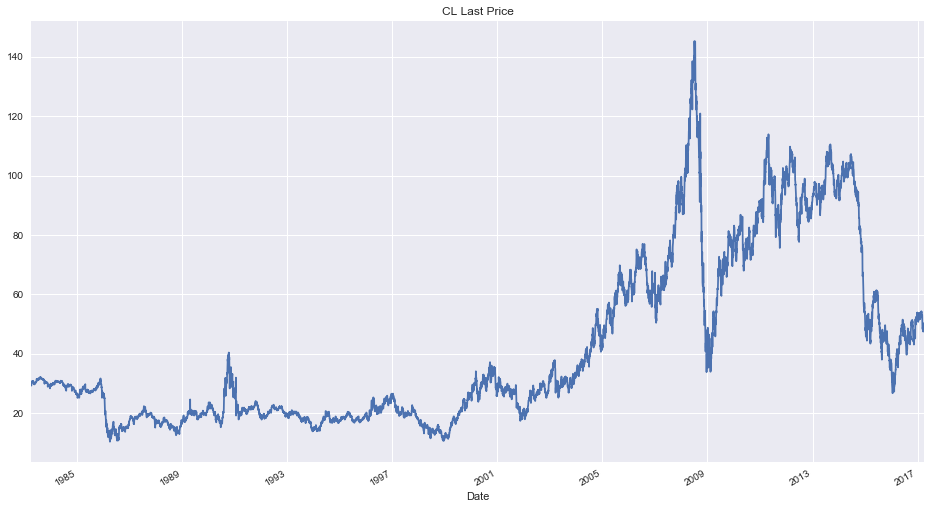

In [4]:
CL.Last.plot(title="CL Last Price", figsize=(16,9))

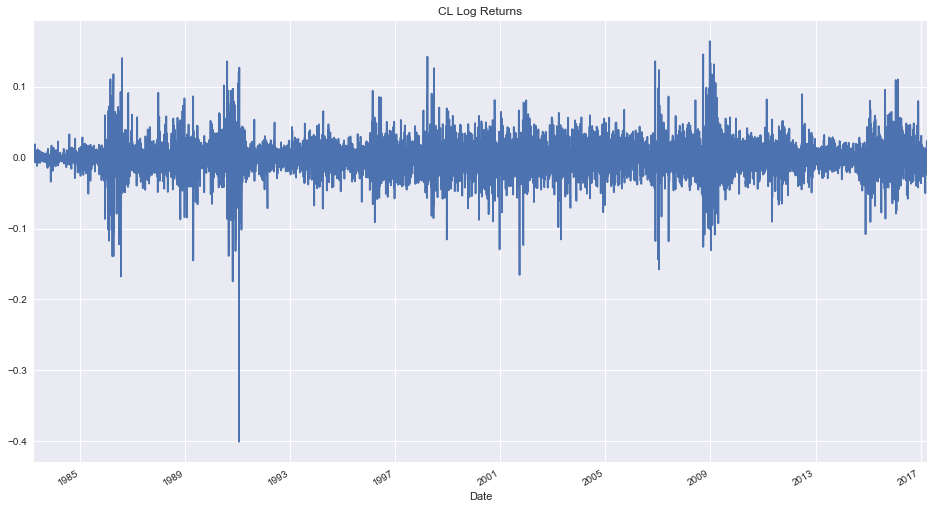

In [5]:
CL.Returns.plot(title="CL Log Returns", figsize=(16,9))

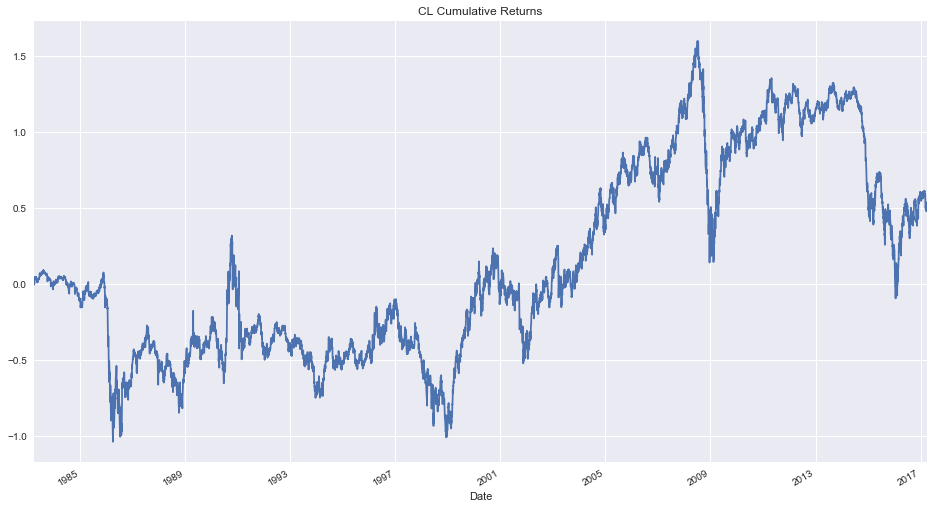

In [6]:
CL["CumRets"] = CL.Returns.cumsum()
CL.CumRets.plot(title="CL Cumulative Returns", figsize=(16,9))

In [7]:
Strategy_returns = pd.DataFrame({"mom_slow": np.nan,
                                "mom_fast": np.nan,
                                "mr_slow": np.nan,
                                "mr_fast": np.nan}, index=CL.index)

## Strategy 1 
Simple Momentum Strategy using a 256 Day look pack. If the cumulative return today is greater then the cumulative return 256 Days ago, go long. If the cumulative return today is less than the previous 256's days cumulative return, go short.

In [8]:
slow_mom_param = 120
mom_slow = (CL.CumRets >= CL["CumRets"].shift(slow_mom_param))
mom_slow[0:slow_mom_param] = np.nan
mom_slow[mom_slow == 0] = -1
mom_slow = mom_slow.shift(1)

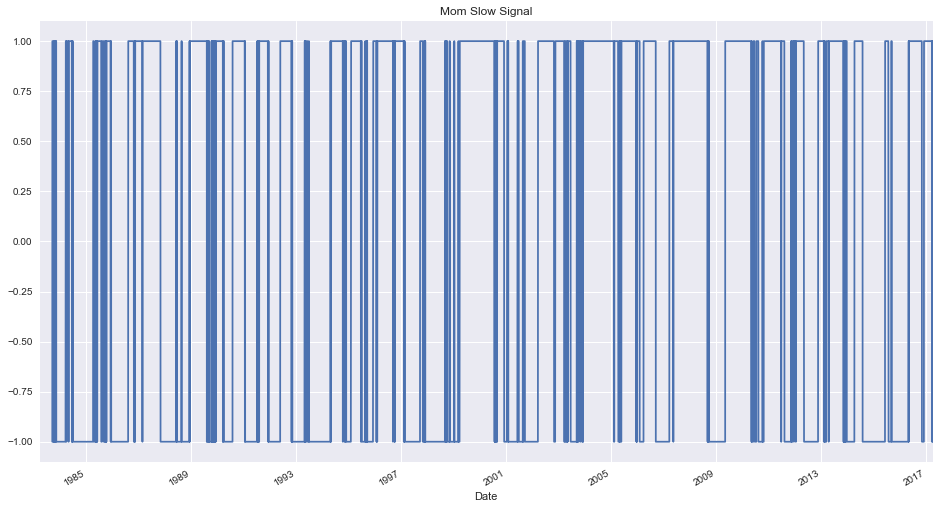

In [9]:
mom_slow.plot(title="Mom Slow Signal", figsize=(16,9))

In [10]:
Strategy_returns["mom_slow"]=  mom_slow * CL.Returns

In [11]:
plot_data = mom_slow["2000-01-01":"2002-01-01"]
long_dates = plot_data[(plot_data == 1) & (plot_data.shift(1) != 1)].index
short_dates = plot_data[(plot_data == -1) & (plot_data.shift(1) != -1)].index

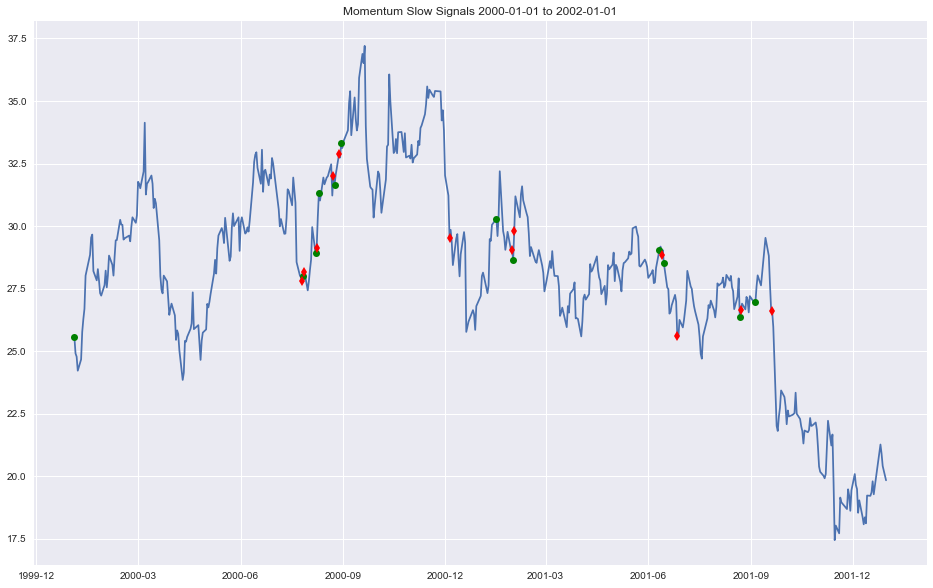

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(CL.Last["2000-01-01":"2002-01-01"], label="CL")
ax.plot(long_dates, CL.Last.loc[long_dates].values, 'go')
ax.plot(short_dates, CL.Last.loc[short_dates].values, 'rd')
plt.title("Momentum Slow Signals 2000-01-01 to 2002-01-01")

## Strategy 2 
Simple Momentum Strategy using a 90 Day look pack. If the cumulative return today is greater then the cumulative return 256 Days ago, go long. If the cumulative return today is less than the previous 90's days cumulative return, go short.

In [13]:
fast_mom_param = 45
mom_fast = (CL.CumRets >= CL["CumRets"].shift(fast_mom_param))
mom_fast[0:fast_mom_param] = np.nan
mom_fast[mom_fast == 0] = -1
mom_fast = mom_fast.shift(1)

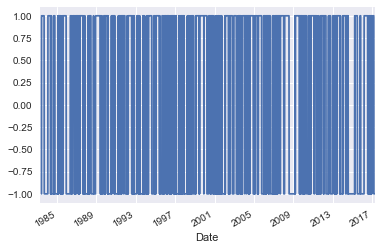

In [14]:
mom_fast.plot()

In [15]:
Strategy_returns["mom_fast"]=  mom_fast * CL.Returns

In [16]:
plot_data = mom_fast["2000-01-01":"2002-01-01"]
long_dates = plot_data[(plot_data == 1) & (plot_data.shift(1) != 1)].index
short_dates = plot_data[(plot_data == -1) & (plot_data.shift(1) != -1)].index

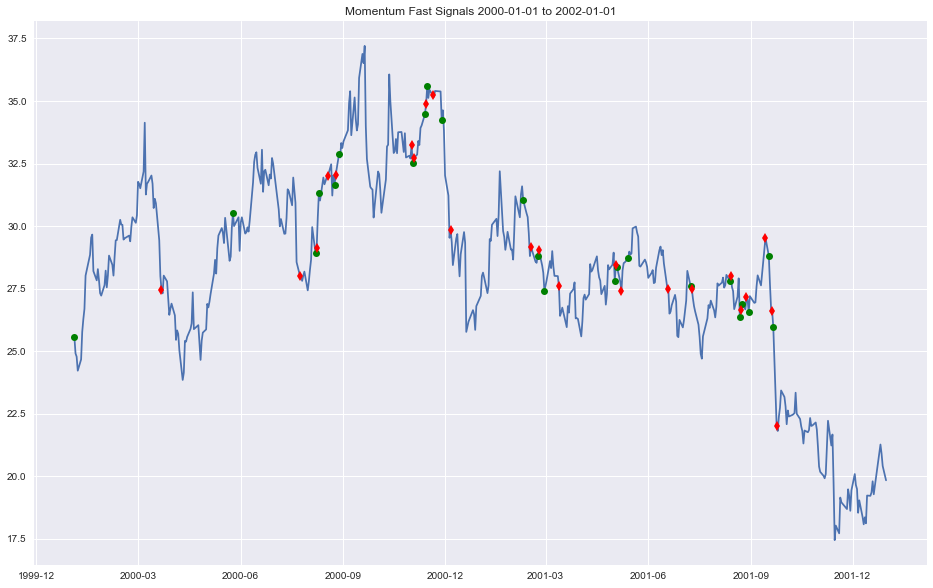

In [17]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(CL.Last["2000-01-01":"2002-01-01"], label="CL")
ax.plot(long_dates, CL.Last.loc[long_dates].values, 'go')
ax.plot(short_dates, CL.Last.loc[short_dates].values, 'rd')
plt.title("Momentum Fast Signals 2000-01-01 to 2002-01-01")

## Strategy 3
Simple Mean reversion strategy using bollinger bands. Using a 45 day look back. If price crosses the lower 3 standard dev band then we go long, if we price crosses the upper we go short. 

In [18]:
mr_fast_param = 45
upperBB, middleBB, lowerBB = talib.BBANDS(CL.Last.values, timeperiod=mr_fast_param, nbdevup=3, nbdevdn=3)

In [19]:
mr_fast = pd.DataFrame({"Last":CL.Last, "Upper": upperBB, "Middle": middleBB, "Lower": lowerBB, "Rets": CL.Returns})
mr_fast.tail()

,Last,Lower,Middle,Rets,Upper
Date,,,,,
2017-03-24,48.14,45.242949,51.893556,0.009811,58.544162
2017-03-27,47.85,44.911171,51.794000,-0.006042,58.676829
2017-03-28,48.45,44.674567,51.696667,0.012461,58.718766
2017-03-29,49.60,44.563385,51.622444,0.023458,58.681504
2017-03-30,50.33,44.508458,51.564444,0.014610,58.620431


In [20]:
mr_fast["Signal"] = np.nan
mr_fast.loc[mr_fast.Last > mr_fast.Upper.shift(1),"Signal"] = -1
mr_fast.loc[mr_fast.Last < mr_fast.Lower.shift(1),"Signal"] = 1
mr_fast.ffill(inplace=True)

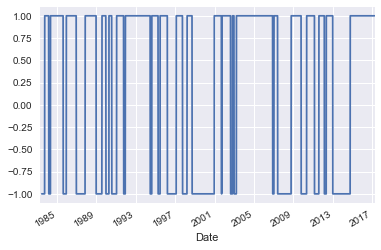

In [21]:
mr_fast.Signal.plot()

In [22]:
Strategy_returns["mr_fast"] = mr_fast["Signal"] * mr_fast["Rets"]

In [23]:
plot_data = mr_fast.loc["2000-01-01":"2005-01-01", "Signal"]
long_dates = plot_data[(plot_data == 1) & (plot_data.shift(1) != 1)].index
short_dates = plot_data[(plot_data == -1) & (plot_data.shift(1) != -1)].index

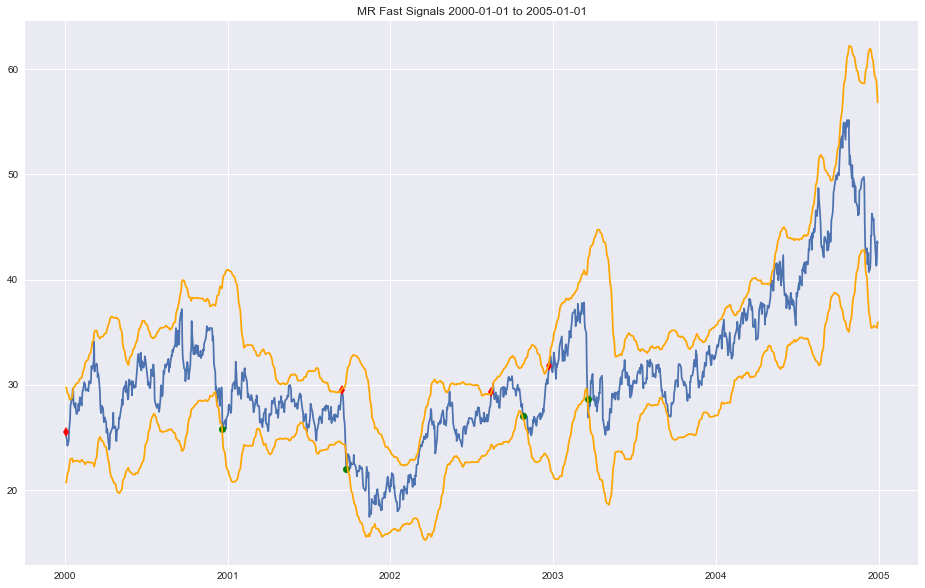

In [24]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(CL.Last["2000-01-01":"2005-01-01"], label="CL")
ax.plot(long_dates, CL.Last.loc[long_dates].values, 'go')
ax.plot(short_dates, CL.Last.loc[short_dates].values, 'rd')
ax.plot(mr_fast.loc["2000-01-01":"2005-01-01", "Upper"], color='orange')
ax.plot(mr_fast.loc["2000-01-01":"2005-01-01", "Lower"],  color='orange')
plt.title("MR Fast Signals 2000-01-01 to 2005-01-01")

## Strategy 4
Simple Mean reversion strategy using bollinger bands. Using a 10 day look back. If price crosses the lower 3 standard dev band then we go long, if we price crosses the upper we go short. 

In [25]:
mr_slow_param = 120
upperBB, middleBB, lowerBB = talib.BBANDS(CL.Last.values, timeperiod=mr_slow_param, nbdevup=3, nbdevdn=3)

In [26]:
mr_slow = pd.DataFrame({"Last":CL.Last, "Upper": upperBB, "Middle": middleBB, "Lower": lowerBB, "Rets": CL.Returns})
mr_slow.tail()

,Last,Lower,Middle,Rets,Upper
Date,,,,,
2017-03-24,48.14,41.842411,50.540667,0.009811,59.238922
2017-03-27,47.85,41.819981,50.534000,-0.006042,59.248019
2017-03-28,48.45,41.802924,50.527833,0.012461,59.252743
2017-03-29,49.60,41.801336,50.527000,0.023458,59.252664
2017-03-30,50.33,41.799260,50.525083,0.014610,59.250907


In [27]:
mr_slow["Signal"] = np.nan
mr_slow.loc[mr_slow.Last > mr_slow.Upper.shift(1),"Signal"] = -1
mr_slow.loc[mr_slow.Last < mr_slow.Lower.shift(1),"Signal"] = 1
mr_slow.ffill(inplace=True)

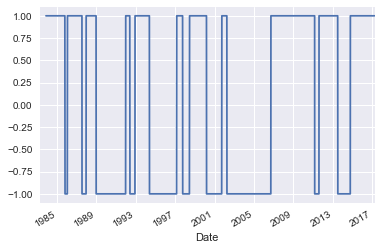

In [28]:
mr_slow.Signal.plot()

In [29]:
mr_slow.tail()

,Last,Lower,Middle,Rets,Upper,Signal
Date,,,,,,
2017-03-24,48.14,41.842411,50.540667,0.009811,59.238922,1.0
2017-03-27,47.85,41.819981,50.534000,-0.006042,59.248019,1.0
2017-03-28,48.45,41.802924,50.527833,0.012461,59.252743,1.0
2017-03-29,49.60,41.801336,50.527000,0.023458,59.252664,1.0
2017-03-30,50.33,41.799260,50.525083,0.014610,59.250907,1.0


In [30]:
Strategy_returns["mr_slow"] = mr_slow["Signal"] * mr_slow["Rets"]

In [31]:
plot_data = mr_slow.loc["2000-01-01":"2005-01-01", "Signal"]
long_dates = plot_data[(plot_data == 1) & (plot_data.shift(1) != 1)].index
short_dates = plot_data[(plot_data == -1) & (plot_data.shift(1) != -1)].index

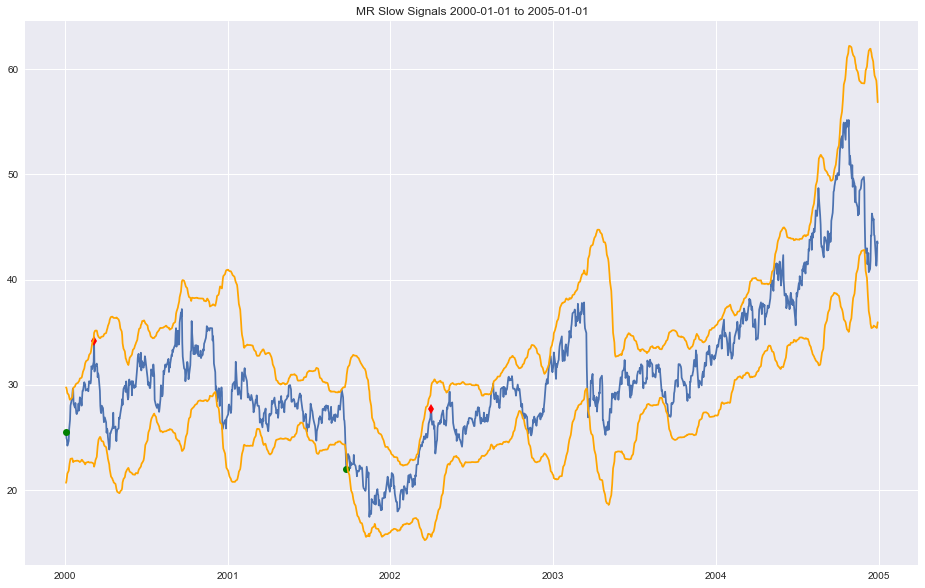

In [32]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(CL.Last["2000-01-01":"2005-01-01"], label="CL")
ax.plot(long_dates, CL.Last.loc[long_dates].values, 'go')
ax.plot(short_dates, CL.Last.loc[short_dates].values, 'rd')
ax.plot(mr_fast.loc["2000-01-01":"2005-01-01", "Upper"], color='orange')
ax.plot(mr_fast.loc["2000-01-01":"2005-01-01", "Lower"],  color='orange')
plt.title("MR Slow Signals 2000-01-01 to 2005-01-01")

# Analysis of Individual Strategies

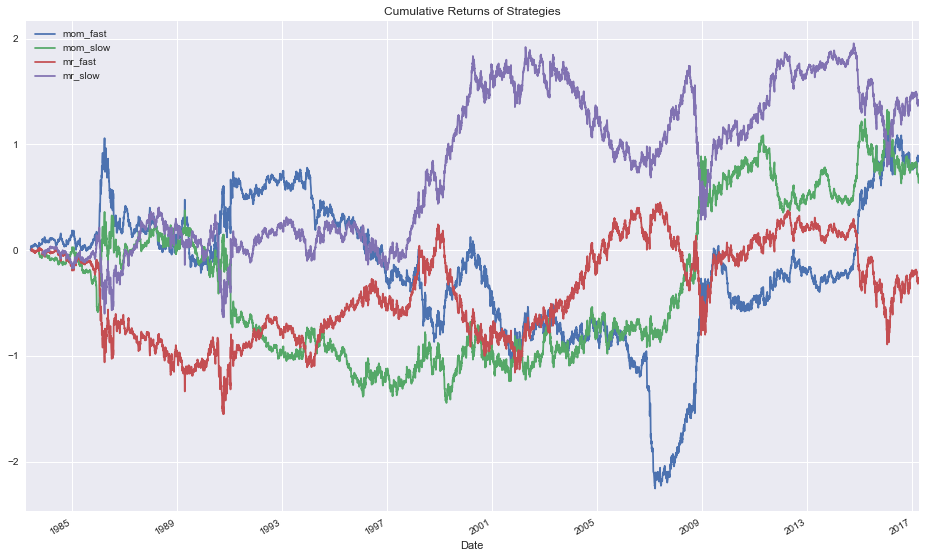

In [33]:
cum_strategy_returns = Strategy_returns.cumsum()
cum_strategy_returns.plot(title="Cumulative Returns of Strategies", figsize=(16,10))

In [34]:
corr = Strategy_returns.corr()
corr

,mom_fast,mom_slow,mr_fast,mr_slow
mom_fast,1.000000,0.450373,-0.334401,-0.210812
mom_slow,0.450373,1.000000,-0.561283,-0.524328
mr_fast,-0.334401,-0.561283,1.000000,0.373784
mr_slow,-0.210812,-0.524328,0.373784,1.000000


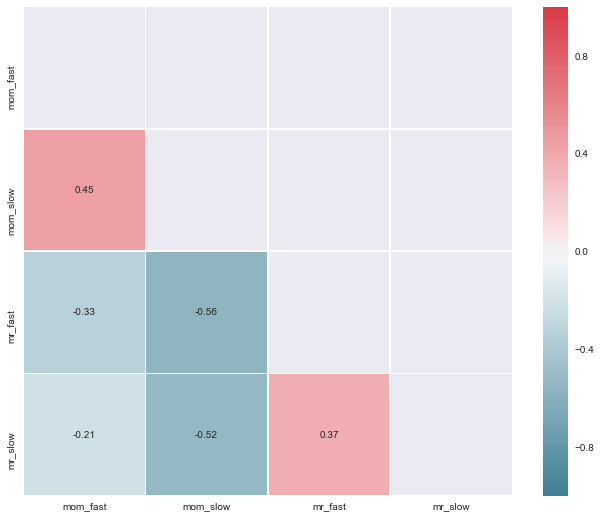

In [35]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax,square=True, center=0, robust=True, annot=True, linewidths=.5)

In [36]:
Strategy_returns.describe()

,mom_fast,mom_slow,mr_fast,mr_slow
count,8497.000000,8422.000000,8489.000000,8381.000000
mean,0.000098,0.000075,-0.000031,0.000170
std,0.024264,0.024369,0.024275,0.024425
min,-0.174480,-0.400478,-0.167610,-0.167610
25%,-0.010922,-0.011061,-0.011615,-0.011261
50%,0.000364,0.000475,-0.000313,0.000000
75%,0.011800,0.011962,0.011104,0.011823
max,0.400478,0.167610,0.400478,0.400478


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022395E1D278>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000022395EA2518>], dtype=object)

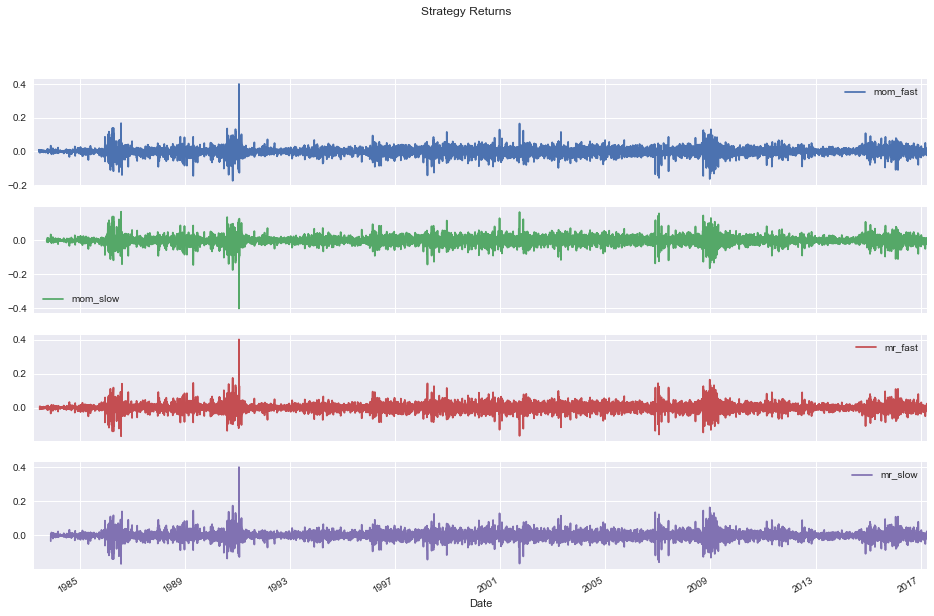

In [37]:
Strategy_returns.plot(title="Strategy Returns", figsize=(16,10),subplots=True)

# Trade Return Distribution Analysis

In [38]:
# Determine when signal changes
trade_index_mom_slow = mom_slow[mom_slow != mom_slow.shift(1)].dropna().index

# loop through 
mom_slow_trade_returns = {}
for i in range(0,len(trade_index_mom_slow)-1):
    mom_slow_trade_returns[i] = Strategy_returns.loc[trade_index_mom_slow[i]:trade_index_mom_slow[i+1], "mom_slow"].sum()
mom_slow_trade_returns = pd.Series(mom_slow_trade_returns)
mom_slow_trade_returns.tail()

327    0.068754
328   -0.016956
329   -0.036921
330   -0.015853
331   -0.018504
dtype: float64

In [39]:
# Determine when signal changes
trade_index_mom_fast = mom_fast[mom_fast != mom_fast.shift(1)].dropna().index

# loop through each signal change and calculate sum of returns from start and end date
mom_fast_trade_returns = {}
for i in range(0,len(trade_index_mom_fast)-1):
    mom_fast_trade_returns[i] = Strategy_returns.loc[trade_index_mom_fast[i]:trade_index_mom_fast[i+1], "mom_fast"].sum()
mom_fast_trade_returns = pd.Series(mom_fast_trade_returns)
mom_fast_trade_returns.tail()

543   -0.115909
544   -0.041201
545    0.030002
546    0.012732
547    0.016655
dtype: float64

In [40]:
# Determine when signal changes
trade_index_mr_slow = mr_slow.Signal[(mr_slow.Signal != mr_slow.Signal.shift(1))].dropna().index

# loop through each signal change and calculate sum of returns from start and end date
mr_slow_trade_returns = {}
for i in range(0,len(trade_index_mr_slow)-1):
    mr_slow_trade_returns[i] = Strategy_returns.loc[trade_index_mr_slow[i]:trade_index_mr_slow[i+1], "mr_slow"].sum()
mr_slow_trade_returns = pd.Series(mr_slow_trade_returns)
mr_slow_trade_returns.tail()

15   -0.898488
16    0.419948
17    0.178163
18    0.199856
19    0.119621
dtype: float64

In [41]:
trade_index_mr_fast = mr_fast.Signal[(mr_fast.Signal != mr_fast.Signal.shift(1))].dropna().index

# loop through each signal change and calculate sum of returns from start and end date
mr_fast_trade_returns = {}
for i in range(0,len(trade_index_mr_fast)-1):
    mr_fast_trade_returns[i] = Strategy_returns.loc[trade_index_mr_fast[i]:trade_index_mr_fast[i+1], "mr_fast"].sum()
mr_fast_trade_returns = pd.Series(mr_fast_trade_returns)
mr_fast_trade_returns.tail()

38   -0.041699
39    0.130571
40   -0.004474
41   -0.124482
42    0.022516
dtype: float64

In [42]:
trade_returns = pd.DataFrame({"MR_Fast": mr_fast_trade_returns,
                             "MR_Slow": mr_slow_trade_returns,
                             "Mom_Fast": mom_fast_trade_returns,
                             "Mom_Slow": mom_slow_trade_returns})
trade_returns.describe()

,MR_Fast,MR_Slow,Mom_Fast,Mom_Slow
count,43.000000,20.000000,548.000000,332.000000
mean,-0.039868,0.049327,0.000126,0.002309
std,0.210495,0.338181,0.095072,0.093475
min,-0.809338,-0.898488,-0.292174,-0.283950
25%,-0.122258,-0.103376,-0.034679,-0.026592
50%,-0.010262,0.036588,-0.011004,-0.010984
75%,0.056604,0.168623,0.013282,0.008227
max,0.548705,0.879611,1.155931,0.656234


In [43]:
trade_returns.skew()

MR_Fast    -0.984016
MR_Slow    -0.291196
Mom_Fast    5.458711
Mom_Slow    3.911095
dtype: float64

In [44]:
trade_returns.kurtosis()

MR_Fast      4.933210
MR_Slow      3.863083
Mom_Fast    52.677114
Mom_Slow    22.283074
dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022393EF0DA0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000022395FE1208>], dtype=object)

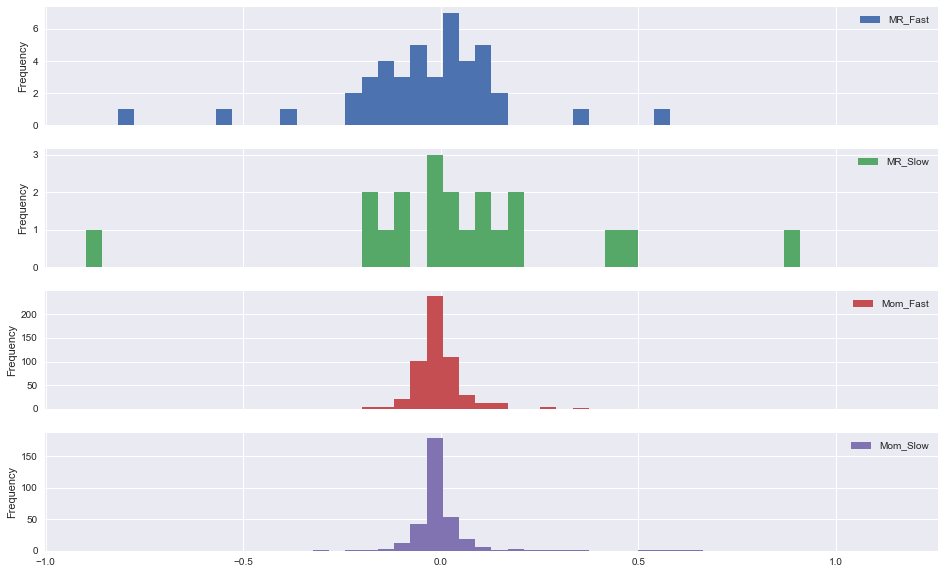

In [45]:
trade_returns.plot(kind="hist", bins=50, subplots=True, figsize=(16,10))

# Portfolio Optimization

In [46]:
# method source https://blog.quantopian.com/markowitz-portfolio-optimization-2/
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio , annualized
    '''

    p = np.asmatrix(np.mean(returns, axis=1)) * 252
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns)) * 252
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2*252:
        return random_portfolio(returns)
    return mu, sigma

In [47]:
return_vec = Strategy_returns.dropna().values.T
return_vec

array([[ 0.03395912, -0.00825598,  0.00171438, ..., -0.01246122,
        -0.0234585 , -0.01461049],
       [ 0.03395912, -0.00825598,  0.00171438, ..., -0.01246122,
        -0.0234585 , -0.01461049],
       [-0.03395912,  0.00825598, -0.00171438, ...,  0.01246122,
         0.0234585 ,  0.01461049],
       [-0.03395912,  0.00825598, -0.00171438, ...,  0.01246122,
         0.0234585 ,  0.01461049]])

In [48]:
n_portfolios = 10000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

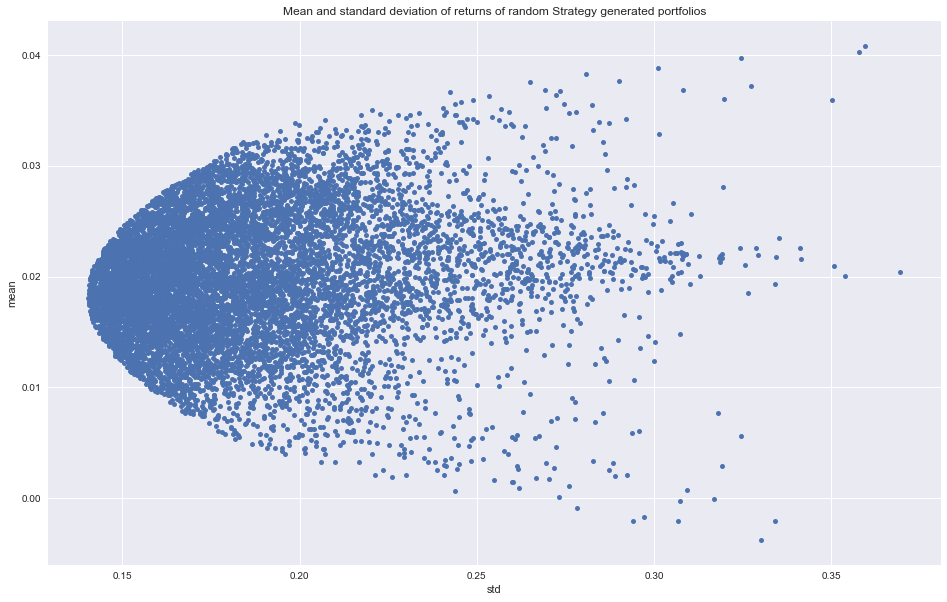

In [49]:
plt.figure(figsize=(16, 10))
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of random Strategy generated portfolios')

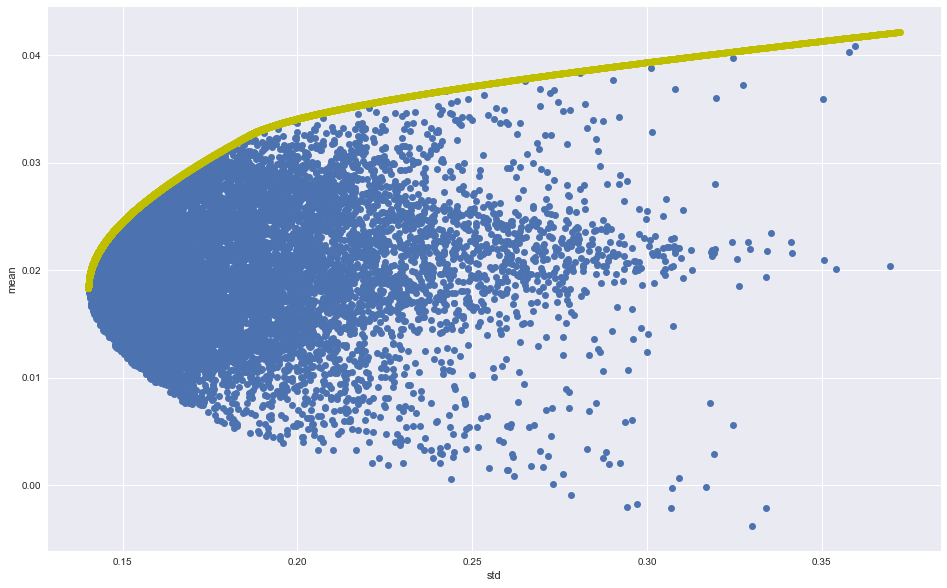

In [50]:
# Turn off progress printing 
solvers.options['show_progress'] = False

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 10000
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.asmatrix(np.cov(returns)*252))
    pbar = opt.matrix(np.asmatrix(np.mean(returns, axis=1)*252))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

plt.figure(figsize=(16, 10))
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')

In [51]:
import scipy.interpolate as sci
import scipy.optimize as sciopt

def getListOfUniqueWithinPrecision(sortedArray):
    ind = 0
    currentVal = 0
    diffToIgnore = 0.00000001
    listOfIndices = [];
    for i in range(sortedArray.size):
        if(sortedArray[i] - diffToIgnore > currentVal):
            listOfIndices.append(i);
            currentVal = sortedArray[i];
    return listOfIndices;

In [52]:
twoRowsArrayForSorting = np.vstack([returns, risks]).T;
rowsAfterSorting = twoRowsArrayForSorting[twoRowsArrayForSorting[:,0].argsort()].T
returnsSorted = rowsAfterSorting[0,:];
risksSorted = rowsAfterSorting[1,:];
listOfInd = getListOfUniqueWithinPrecision(risksSorted);
risksSorted  = risksSorted[listOfInd];
returnsSorted  = returnsSorted[listOfInd];
ind = np.argmin(risksSorted)
evols = risksSorted[ind:]
erets = returnsSorted[ind:]
tck = sci.splrep(evols, erets)

In [53]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

def equations(p, rf=0.0091):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sciopt.fsolve(equations, [0.0091, 0.5, 0.05])

opt

array([ 0.0091    ,  0.12632632,  0.18951455])

In [54]:
np.round(equations(opt), 5)

array([ 0.,  0., -0.])

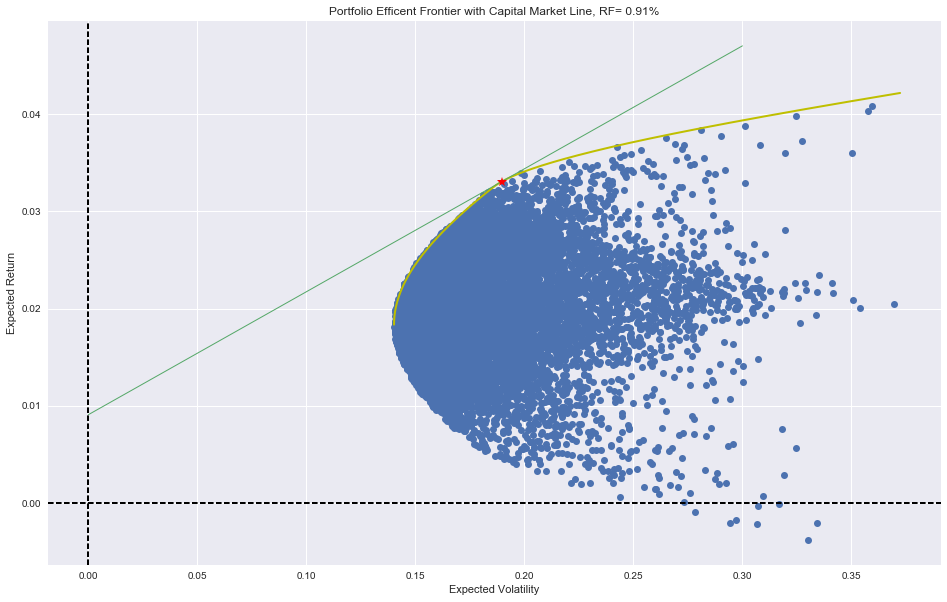

In [55]:
plt.figure(figsize=(16, 10))
plt.plot(stds, means, 'o')
            # random portfolio composition
plt.plot(evols, erets, 'y', lw=2.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.0)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=11.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title("Portfolio Efficent Frontier with Capital Market Line, RF= 0.91%")


In [56]:
weights = pd.DataFrame(weights, index=Strategy_returns.columns)*100
weights.columns=["Percent"]
round(weights, 2)

,Percent
mom_fast,0.0
mom_slow,0.0
mr_fast,0.0
mr_slow,100.0


# Performance Reports

In [57]:
Strategy_returns.mean()/Strategy_returns.std()

mom_fast    0.004059
mom_slow    0.003094
mr_fast    -0.001265
mr_slow     0.006941
dtype: float64